#### The aim of this data analysis is twofold: first, to develop a model that can accurately forecast property prices in Beijing, China, and secondly, to construct a model that categorizes properties as either underpriced or overpriced relative to their original listing price.

1. Initially, the focus is on cleaning and preprocessing the data, followed by constructing a regression model capable of predicting property prices based on various property features.

2. Moving on to the second phase of the analysis, K-means clustering is utilized to group properties according to their features. Subsequently, each cluster is examined to identify properties that significantly deviate from the cluster's average price, thereby identifying underpriced and overpriced properties.

In [28]:
# Loading the necessary libraries
import re
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from gower import gower_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, silhouette_score, r2_score

#### Data Dictionary:
1. url: the url which fetches the data
2. id: the id of transaction
3. Lng: Longitudes 
4. Lat: Latitudes
5. Cid: community id
6. tradeTime: the time of transaction
7. DOM: active days on market
8. followers: the number of people following the transaction.
9. totalPrice: the total price
10. price: the average price by square
11. square: the total area of the house
12. livingRoom: the number of living rooms
13. drawingRoom: the number of drawing rooms
14. kitchen: the number of kitchen
15. bathroom: the number of bathrooms
16. floor: the height of the house
17. buildingType: including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).
18. constructionTime: the time of construction
19. renovationCondition: including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )
20. buildingStructure: including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).
21. ladderRatio: the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average.
22. elevator have ( 1 ) or not have elevator( 0 )
23. fiveYearsProperty: if the owner have the property for less than 5 years

In [2]:
# Setting the seed and loading the dataset
np.random.seed(99)
df = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Beijing_Housing.csv', encoding='ISO-8859-1')
df

C:\Users\himan\AppData\Local\Temp\ipykernel_16276\1512002212.py:3: DtypeWarning: Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Beijing_Housing.csv', encoding='ISO-8859-1')


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160869,https://bj.lianjia.com/chengjiao/BJYZ92299606....,BJYZ92299606,116.550348,39.755625,1111027381517,2016-06-10,1.0,6,268.0,22709,...,4.0,2006,4,6,0.500,0.0,1.0,0.0,3,33518.0
160870,https://bj.lianjia.com/chengjiao/BJYZ92303482....,BJYZ92303482,116.546899,39.755236,1111027377053,2016-06-09,1.0,8,355.5,26491,...,3.0,2009,4,6,0.500,1.0,1.0,0.0,3,36545.0
160871,https://bj.lianjia.com/chengjiao/BJYZ92311192....,BJYZ92311192,116.546899,39.755236,1111027377053,2016-06-10,1.0,8,350.0,20580,...,4.0,2003,1,6,0.333,0.0,1.0,0.0,3,36545.0
160872,https://bj.lianjia.com/chengjiao/BJYZ92324217....,BJYZ92324217,116.497256,39.804081,1111027380056,2016-06-05,1.0,2,359.0,35138,...,4.0,2000,3,6,0.500,1.0,1.0,0.0,3,46927.0


#### Data Preprocessing: 
1. Some columns have been dropped as they aren't important in the analysis. 
2. As the total null values in the dataset are only ~1%, those rows have been dropped from the dataset.
3. The column 'floor' had unrecognizable non-numeric characters along with numeric characters. The numeric characters have been extracted and the non-numeric characters deleted.
4. Some other columns that had numbers as strings have been converted to integer types for building the regression model later on.
5. The column 'tradeTime' was in string format. It was converted to a date type and then year, month and day have been extracted as new columns from it as integer types.
6. Some Variables that are categorical, their type has been defined as 'category' for building the regression model. 

In [3]:
columnsToDrop = ['url','id','Cid','price']
df = df.drop(columns=columnsToDrop)
nullValuesPercent = round((df.isnull().sum()/len(df))*100,2)
print(f'percentage of null values by column: \n{nullValuesPercent}')

percentage of null values by column: 
Lng                    0.00
Lat                    0.00
tradeTime              0.00
DOM                    0.00
followers              0.00
totalPrice             0.00
square                 0.00
livingRoom             0.00
drawingRoom            0.00
kitchen                0.00
bathRoom               0.00
floor                  0.00
buildingType           0.82
constructionTime       0.00
renovationCondition    0.00
buildingStructure      0.00
ladderRatio            0.00
elevator               0.02
fiveYearsProperty      0.02
subway                 0.02
district               0.00
communityAverage       0.13
dtype: float64


In [4]:
df.dropna(inplace=True)
df.shape

(159376, 22)

In [5]:
cols = ['tradeTime','livingRoom','drawingRoom','bathRoom','floor','constructionTime']
for col in cols:
    print(f'{col}:{df[col].unique()}')

tradeTime:['2016-08-09' '2016-07-28' '2016-12-11' ... '2014-06-02' '2014-08-04'
 '2014-05-01']
livingRoom:[2 3 1 4 5 6 0 7 '3' '1' '4' '2' '7' '5' '0' '6']
drawingRoom:[1 2 0 4 3 '1' '2' '3' '0' '4' '5']
bathRoom:[1 2 3 0 4 5 6 '2' '1' '0' '3' '4' '6' '5']
floor:['Â¸Ã\x9f 26' 'Â¸Ã\x9f 22' 'Ã\x96Ã\x90 4' 'ÂµÃ\x97 21' 'Ã\x96Ã\x90 6'
 'Ã\x96Ã\x90 8' 'Â¸Ã\x9f 6' 'Â¸Ã\x9f 10' 'Ã\x96Ã\x90 23' 'ÂµÃ\x97 11'
 'Â¸Ã\x9f 24' 'ÂµÃ\x8d 23' 'Ã\x96Ã\x90 19' 'Â¸Ã\x9f 18' 'ÂµÃ\x8d 25'
 'Ã\x96Ã\x90 12' 'Ã\x96Ã\x90 14' 'Ã\x96Ã\x90 30' 'Ã\x96Ã\x90 27'
 'Ã\x96Ã\x90 5' 'ÂµÃ\x8d 18' 'ÂµÃ\x97 28' 'Ã\x96Ã\x90 11' 'ÂµÃ\x8d 9'
 'Â¶Â¥ 7' 'Â¶Â¥ 27' 'ÂµÃ\x8d 6' 'Ã\x96Ã\x90 17' 'Â¶Â¥ 6' 'Ã\x96Ã\x90 24'
 'Ã\x96Ã\x90 15' 'ÂµÃ\x97 5' 'Ã\x96Ã\x90 29' 'Â¶Â¥ 19' 'Â¶Â¥ 5'
 'Ã\x96Ã\x90 9' 'ÂµÃ\x8d 22' 'Â¶Â¥ 18' 'ÂµÃ\x8d 16' 'Â¸Ã\x9f 13'
 'Â¸Ã\x9f 9' 'Â¸Ã\x9f 17' 'ÂµÃ\x97 6' 'Ã\x96Ã\x90 28' 'ÂµÃ\x8d 26'
 'ÂµÃ\x97 15' 'Â¸Ã\x9f 16' 'ÂµÃ\x8d 7' 'Ã\x96Ã\x90 13' 'ÂµÃ\x8d 33'
 'ÂµÃ\x97 14' 'Â¸Ã\x9f 15' 'Â¶Â¥ 11' 'Ã\x96Ã\x90 32' 'Â¶

In [6]:
def extractNumeric(s):
    return re.sub(r'\D','',s)
df['floor'] = df['floor'].apply(extractNumeric)

cols = cols[1:]
for col in cols:
    df[col] = pd.to_numeric(df[col],errors='coerce')

meanConstructionTime = round(df['constructionTime'].mean())
df['constructionTime'].fillna(meanConstructionTime, inplace=True)

df['tradeTime'] = pd.to_datetime(df['tradeTime'])
df['tradeYear'] = df['tradeTime'].dt.year
df['tradeMonth'] = df['tradeTime'].dt.month
df['tradeDay'] = df['tradeTime'].dt.day
df.drop(columns=['tradeTime'], inplace=True)

<Axes: >

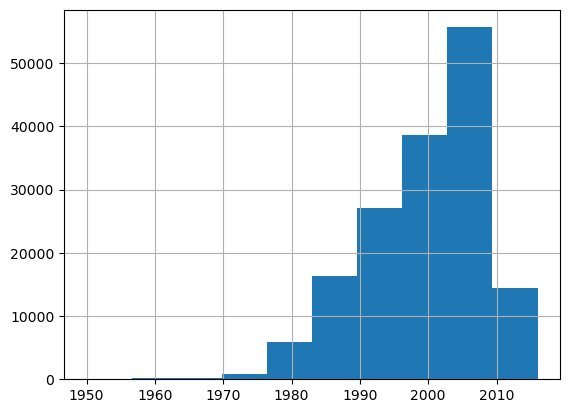

In [26]:
df['constructionTime'].hist()

In [7]:
catCols = ['buildingType','renovationCondition','buildingStructure','elevator','fiveYearsProperty','subway','district']
for col in catCols:
    df[col] = df[col].astype('category')

#### Regression Model:
Light Gradient Boosting Machine (LGBM) is chosen for building the regression model. LGBM is chosen because it is known for its efficiency in training and inference, especially on large datasets. It implements gradient boosting algorithms, which generally train faster than traditional ensemble methods like Random Forest. It also generally outperforms both Random Forest and Linear Regression in terms of predictive accuracy.

The column 'totalPrice' is chosen as the target variable. The dataset is split into training and testing sets. Based on the training results the top 10 important features out of the 23 features are selected. Testing is done once with all the features and then with only the top 10 features. The RMSE in both cases is same ~107. Also the R^2 value in both the cases is ~81%.

In [8]:
# Dividing the data into target variable and the independent variables and also into training and testing sets
X = df.drop(columns=['totalPrice'])
y = df['totalPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [31]:
# Defining the parameters of the lgbm model
params = {'boosting_type': 'dart',
          'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': 31,
          'learning_rate': 0.05,
          'feature_fraction': 0.9,
          'seed': 99}

trainData = lgb.Dataset(X_train, label=y_train, categorical_feature=catCols)
testData = lgb.Dataset(X_test, label=y_test, categorical_feature=catCols, reference=trainData)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1904
[LightGBM] [Info] Number of data points in the train set: 127500, number of used features: 23
[LightGBM] [Info] Start training from score 409.377336
{'feature_fraction': 0.9}


In [10]:
model = lgb.train(params, trainData, num_boost_round=100, valid_sets=[testData])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1904
[LightGBM] [Info] Number of data points in the train set: 127500, number of used features: 23
[LightGBM] [Info] Start training from score 409.377336


In [11]:
# Important Variables in predicting the price in decreasing order 
featureImportance = model.feature_importance(importance_type='gain')

featureImportanceDf = pd.DataFrame({'Feature': model.feature_name(), 'Importance': featureImportance})

featureImportanceDf = featureImportanceDf.sort_values(by='Importance', ascending=False)

print(featureImportanceDf)

                Feature    Importance
4                square  6.622094e+10
19     communityAverage  5.334922e+10
20            tradeYear  1.739085e+10
2                   DOM  1.407755e+10
18             district  5.806078e+09
8              bathRoom  1.796832e+09
21           tradeMonth  7.694184e+08
5            livingRoom  5.460086e+08
11     constructionTime  1.325027e+08
0                   Lng  1.298598e+08
1                   Lat  1.247739e+08
14          ladderRatio  7.813243e+07
3             followers  4.208859e+07
15             elevator  1.716025e+07
12  renovationCondition  8.658620e+06
13    buildingStructure  3.162620e+06
10         buildingType  0.000000e+00
16    fiveYearsProperty  0.000000e+00
17               subway  0.000000e+00
9                 floor  0.000000e+00
7               kitchen  0.000000e+00
6           drawingRoom  0.000000e+00
22             tradeDay  0.000000e+00


In [12]:
# Predicting on the test set using all the features
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 107.88755984222088
R^2: 0.8144671341774744


In [13]:
topFeatures = featureImportanceDf.head(10)['Feature'].tolist()
print(f'The 10 most important features are: \n{topFeatures}')

The 10 most important features are: 
['square', 'communityAverage', 'tradeYear', 'DOM', 'district', 'bathRoom', 'tradeMonth', 'livingRoom', 'constructionTime', 'Lng']


In [14]:
# Predicting on the test set using only the top 10 features
newCatCol = ['district']

X_train_top = X_train[topFeatures]
X_test_top = X_test[topFeatures]

trainDataTop = lgb.Dataset(X_train_top, label=y_train, categorical_feature=newCatCol)
testDataTop = lgb.Dataset(X_test_top, label=y_test, categorical_feature=newCatCol, reference=trainDataTop)

modelTop = lgb.train(params, trainDataTop, num_boost_round=100, valid_sets=[testDataTop])

y_pred_top = modelTop.predict(X_test_top, num_iteration=modelTop.best_iteration)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 127500, number of used features: 10
[LightGBM] [Info] Start training from score 409.377336


In [15]:
rmseTop = np.sqrt(mean_squared_error(y_test, y_pred_top))

r2Top = r2_score(y_test, y_pred_top)

print("RMSE:", rmseTop)
print("R^2:", r2Top)

RMSE: 107.75417981563106
R^2: 0.8149255944818011


Below is a scatter plot showing most of the predicted prices lying within a 95% confidence interval of the actual prices. 

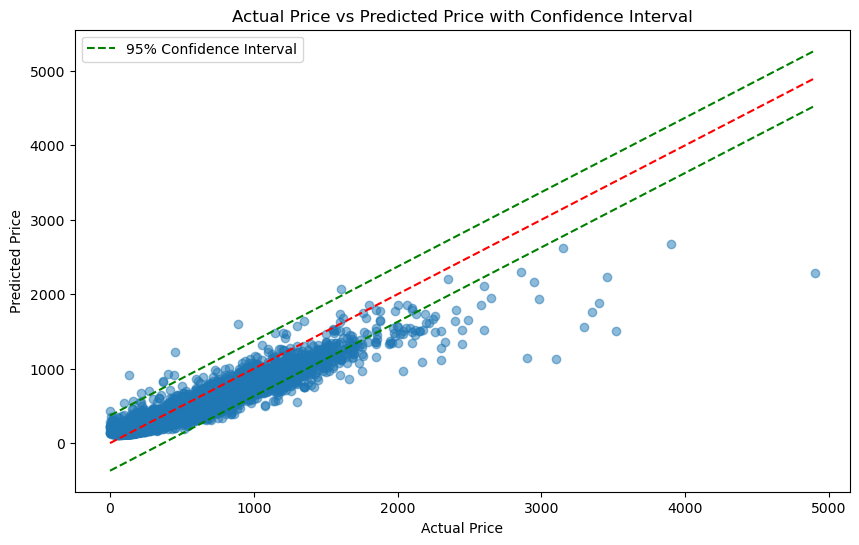

In [16]:
confidence_interval = 1.96 * np.std(y_pred_top)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_top, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test) - confidence_interval, max(y_test) - confidence_interval], '--', color='green', label='95% Confidence Interval')
plt.plot([min(y_test), max(y_test)], [min(y_test) + confidence_interval, max(y_test) + confidence_interval], '--', color='green')
plt.title('Actual Price vs Predicted Price with Confidence Interval')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

#### Classification of Properties as Underpriced or Overpriced.
1. A subset of the dataframe consisting of only the top ten features and the target variable 'totalPrice' is created. This is to reduce the curse of dimensionality while using K-Means. Even though the variable 'Lat': Latitude is not in the top 10 features, it is included becuase it is used later on in the analysis to locate the properties on a map.
2. As the computational speed becomes very slow with a large dataset while using K-Means, so a random sample of 2000 rows is selected to work on.
3. Since the dataset consists of a mix of continuous and categorical variables, it is preprocessed by calculating the Gower's distance of the variables before plugging into the K-Means model.

In [17]:
subsetDf = df[topFeatures] 
subsetDf['totalPrice'] = df['totalPrice']
subsetDf['Lat'] = df['Lat']

C:\Users\himan\AppData\Local\Temp\ipykernel_16276\4027769544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsetDf['totalPrice'] = df['totalPrice']
C:\Users\himan\AppData\Local\Temp\ipykernel_16276\4027769544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsetDf['Lat'] = df['Lat']


In [18]:
# Taking a random sample of 2000
randomSample = subsetDf.sample(n=2000, random_state=78, replace=False)
selectedCols = [col for col in randomSample.columns if col != 'totalPrice']
selectedData = randomSample[selectedCols]

selectedData = selectedData.apply(lambda x: x.astype('category').cat.codes if x.dtype.name == 'category' else x)

# Calculating the gower's distance
distanceMatrix = gower_matrix(selectedData)

#### Number of Clusters:
The ideal number of clusters to be used in K-Means can be decided by different methods. Two methods are used here:

1. The Elbow Method: The idea is to select the value of k at the "elbow" point, as it represents the point where increasing the number of clusters does not significantly decrease the within-cluster sum of squares or the Inertia. Based on the plot the cluster value at the elbow is 3.

2. The Silhouette Score Method: The objective of clustering is to group similar data points together while keeping dissimilar points in different clusters. A high average Silhouette Score indicates that this objective is being achieved effectively. Based on this method the ideal cluster value is 2.

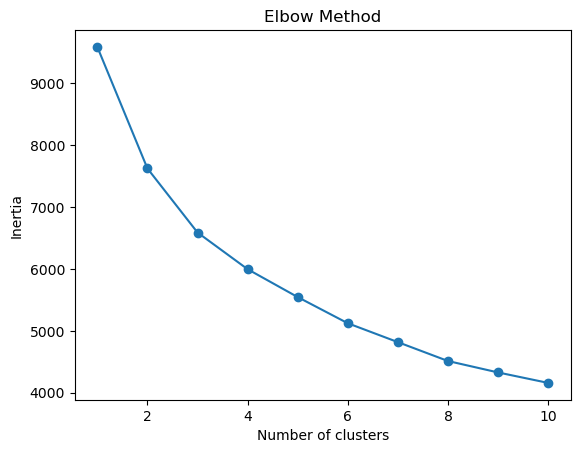

In [19]:
inertia = []
for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(distanceMatrix)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

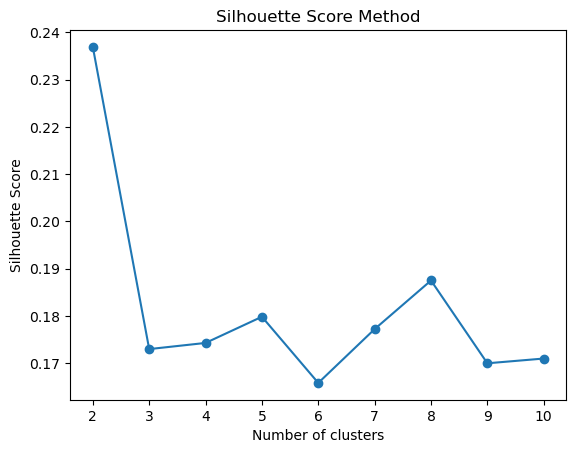

In [20]:
silhouetteScores = []
for k in range(2, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(distanceMatrix)
    score = silhouette_score(distanceMatrix, kmeans.labels_)
    silhouetteScores.append(score)

plt.plot(range(2, 11), silhouetteScores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

In [21]:
# no. of clusters = 3
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(distanceMatrix)
cluster_labels = kmeans.labels_

The properties are divided among 3 clusters based on the 10 features selected earlier. The following graph and the summary statistics are based on the prices of properties within each cluster.

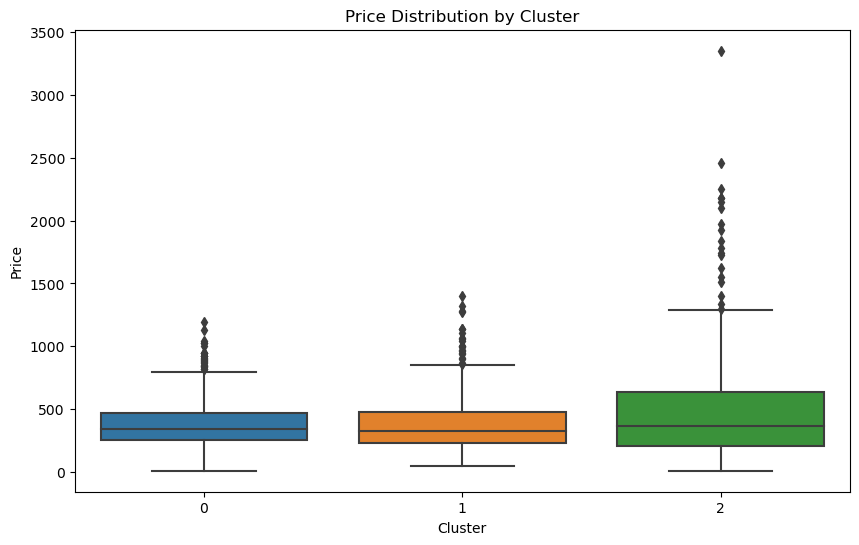

In [22]:
clusterPrices = pd.DataFrame({'Cluster': cluster_labels, 'Price': randomSample['totalPrice']})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Price', data=clusterPrices)
plt.title('Price Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Price')
plt.show()

In [23]:
clusterSummaryStats = clusterPrices.groupby('Cluster')['Price'].describe()

print("Summary statistics for each cluster:")
print(clusterSummaryStats)

Summary statistics for each cluster:
         count        mean         std   min     25%    50%    75%     max
Cluster                                                                   
0        952.0  381.227521  176.919966  11.2  253.00  345.0  472.0  1190.0
1        627.0  380.086284  213.558944  50.0  229.75  330.0  480.0  1400.0
2        421.0  498.329454  428.490219  11.1  205.00  368.0  638.0  3350.0


The method of classifying a property as underpriced or overpriced is based on calculating the mean price and standard deviation of each cluster. Any property within a cluster, if its price is more than one standard deviation than the mean, it is classified as overpriced. If its price is less than one standard deviation of the mean price of its cluster, then it is classified as underpriced.

The following table shows the datapoints classified as such. Of the 2000 data points analayzed, 483 or around 1/4th are either underpriced or overpriced.

In [24]:
clusterAvgPrice = clusterPrices.groupby('Cluster')['Price'].mean()

clusterPrices['ClusterAvgPrice'] = clusterPrices['Cluster'].map(clusterAvgPrice)

clusterStd = clusterPrices.groupby('Cluster')['Price'].std()

clusterPrices['ClusterStd'] = clusterPrices['Cluster'].map(clusterStd)

thresholdMultiplier = 1 
overpriced = clusterPrices[clusterPrices['Price'] > clusterPrices['ClusterAvgPrice'] + thresholdMultiplier * clusterPrices['ClusterStd']]
underpriced = clusterPrices[clusterPrices['Price'] < clusterPrices['ClusterAvgPrice'] - thresholdMultiplier * clusterPrices['ClusterStd']]

overpricedIndices = overpriced.index
underpricedIndices = underpriced.index

overpricedDf = randomSample.loc[overpricedIndices].copy()
underpricedDf = randomSample.loc[underpricedIndices].copy()
overpricedDf = overpricedDf.assign(PricedType='Overpriced')
underpricedDf = underpricedDf.assign(PricedType='Underpriced')

overOrUnderPricedDf = pd.concat([overpricedDf, underpricedDf])

overOrUnderPricedDf 

,square,communityAverage,tradeYear,DOM,district,bathRoom,tradeMonth,livingRoom,constructionTime,Lng,totalPrice,Lat,PricedType
37042,51.01,119449.0,2016,16.0,10,1,9,1,2003.0,116.387037,583.0,39.959170,Overpriced
79302,107.30,60013.0,2017,68.0,7,1,8,2,2004.0,116.518451,597.0,39.924010,Overpriced
60670,107.41,94271.0,2017,43.0,1,1,3,3,2006.0,116.429963,1320.0,39.963815,Overpriced
35429,83.00,75858.0,2016,5.0,8,1,9,3,1990.0,116.292014,580.0,39.928693,Overpriced
88863,117.47,52197.0,2017,20.0,6,2,11,2,2004.0,116.363152,562.5,40.089008,Overpriced
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14148,54.00,46072.0,2016,25.0,7,1,7,1,2007.0,116.512916,168.0,39.864254,Underpriced
95227,61.89,37661.0,2015,1.0,6,1,3,1,2002.0,116.415742,140.0,40.077796,Underpriced
118720,37.93,59730.0,2016,1.0,7,1,5,1,2007.0,116.584680,157.0,39.935758,Underpriced
93145,128.71,38281.0,2011,1.0,6,2,12,3,2004.0,116.439341,46.7,40.082372,Underpriced


The following is a street map of Beijing showing the overpriced (in Red) and underpriced (in Green) properties.

In [25]:
map = folium.Map(location=[overOrUnderPricedDf ['Lat'].mean(), overOrUnderPricedDf ['Lng'].mean()], zoom_start=10, tiles='CartoDB positron', lang='en')

colors = {'Underpriced': 'green', 'Overpriced': 'red'}

for index, row in overOrUnderPricedDf .iterrows():
    folium.Marker([row['Lat'], row['Lng']], icon=folium.Icon(color=colors[row['PricedType']])).add_to(map)

map 